papers http://proceedings.mlr.press/v80/ruff18a.html https://arxiv.org/abs/1906.02694
    
papers code https://github.com/lukasruff/Deep-SVDD-PyTorch https://github.com/lukasruff/Deep-SAD-PyTorch

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd
from seaborn import boxplot
import random
from torch.optim.lr_scheduler import MultiStepLR

from utils import *
from networks import *
from centroids import *
from batchscores import *
from epochscores import *

In [3]:
nbr_epochs = 250 # paper says 150 + 100
batch_size = 512 # paper says 200
# dataset = 'MNIST'
dataset = 'FashionMNIST'
# dataset = 'CIFAR10'
normal_cls = [0,1,2]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4
use_pretraining = False # paper says True

In [4]:
nbr_seeds = 3 # how many different random init to try
valid_AUCs = torch.zeros((nbr_seeds, nbr_epochs+1))
test_AUCs = torch.zeros((nbr_seeds, nbr_epochs+1))
losses = torch.zeros((nbr_seeds, nbr_epochs))

/home/blupon/anaconda3/envs/recent/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
100%|██████████| 250/250 [02:50<00:00,  1.47it/s]


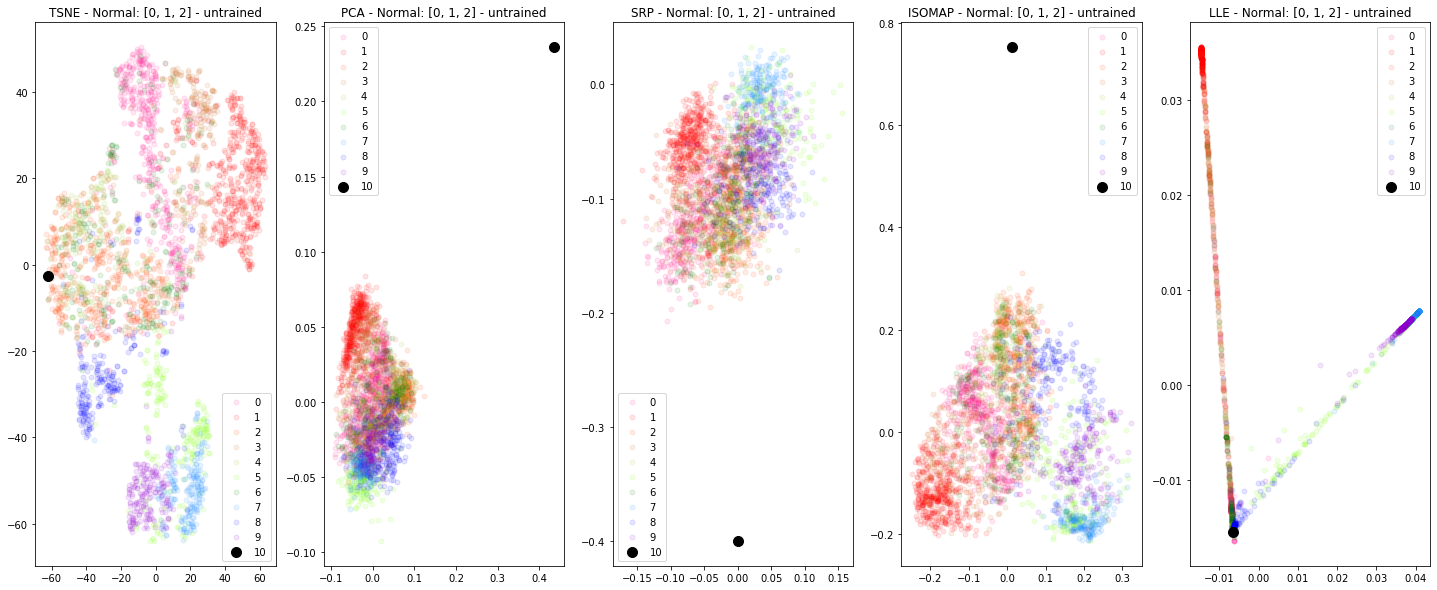

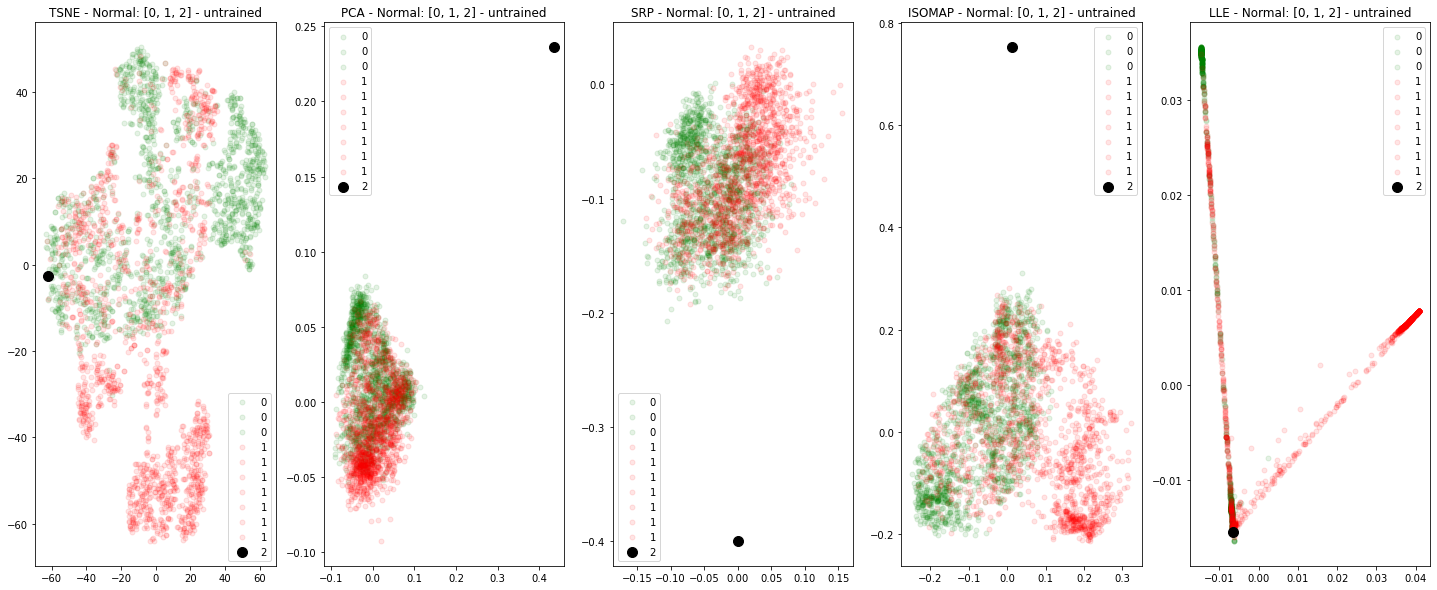

100%|██████████| 250/250 [02:58<00:00,  1.40it/s]


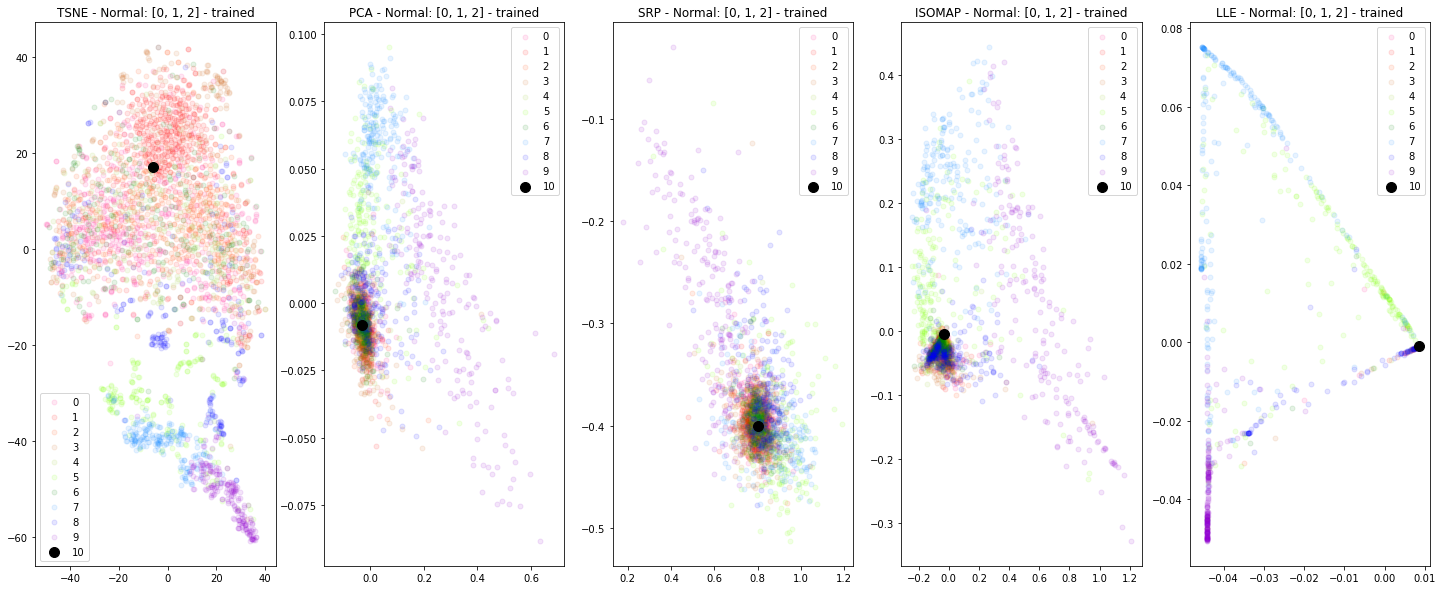

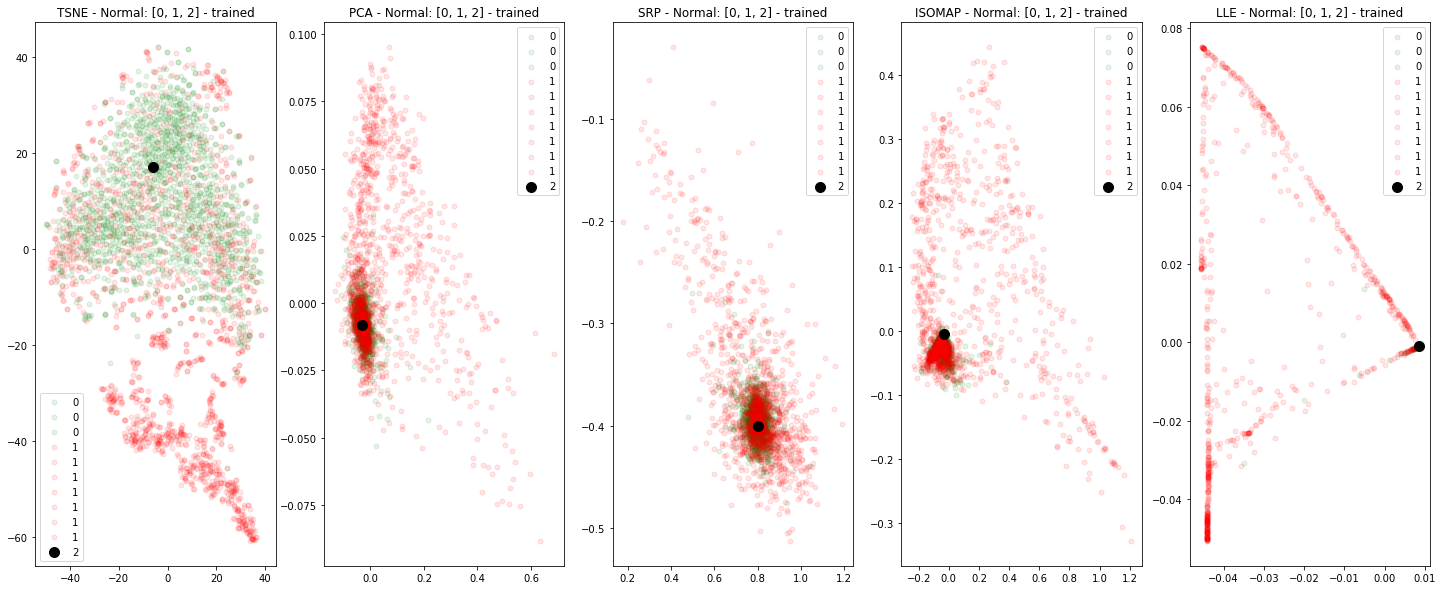

In [5]:
for seed_idx in range(nbr_seeds):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)

    train_loader, valid_loader, test_loader, _, _, _, _, _, _ = get_dataloaders_MNIST_FashionMNIST(batch_size, normal_cls, dataset, seed=seed_idx)
    if dataset == 'MNIST':
        net = MNIST_LeNet().to(device)
    elif dataset == 'FashionMNIST':
        net = FashionMNIST_LeNet().to(device)
    else:
        net = CIFAR10_LeNet().to(device)
    if use_pretraining:
        net = init_network_weights_from_pretraining(net, dataset, normal_cls, seed_idx)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
    scheduler = MultiStepLR(optimizer, milestones=[150], gamma=0.1)
    pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    hypersphere_center = init_center_c_mode_mean(device, train_loader, net)
    
    valid_AUCs[seed_idx,0], test_AUCs[seed_idx,0], _, _, _ = get_epoch_performances_baseline(valid_loader, test_loader, device, net, hypersphere_center, normal_cls)
    
    # plot latent distribution before and after training only for last seed in order not to flood the notebook with graphs
    if seed_idx == nbr_seeds-1:
        plot_distribution(test_loader, net, hypersphere_center, device, "untrained", normal_cls)
    
    for epoch in tqdm(range(nbr_epochs), position=0, leave=True):
        net.train()
        running_loss = 0.0
        for i, (data,targets) in enumerate(train_loader, 0):
            inputs, labels = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            dist = torch.sum((outputs - hypersphere_center) ** 2, dim=1)
            loss = torch.mean(dist)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses[seed_idx,epoch] = running_loss

        valid_AUCs[seed_idx,epoch+1],test_AUCs[seed_idx,epoch+1], scores_test, scores_labels_test, scores_per_center_test = get_epoch_performances_baseline(valid_loader, test_loader, device, net, hypersphere_center, normal_cls)
        
        scheduler.step()
    
plot_distribution(test_loader, net, hypersphere_center, device, "trained", normal_cls)

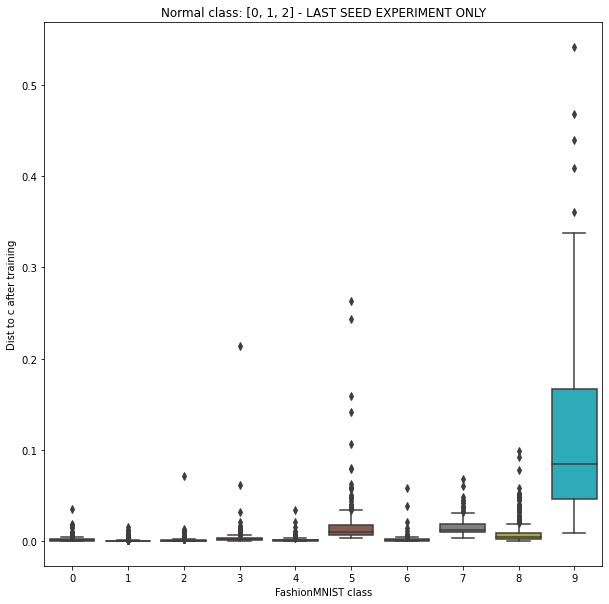

In [6]:
plt.figure(figsize=(10, 10))
boxplot(y=scores_test, x=scores_labels_test)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Dist to c after training') # minimum over all centroids for test samples
plt.title('Normal class: {} - LAST SEED EXPERIMENT ONLY'.format(normal_cls))
plt.show()

Text(0.5, 1.0, 'NormClass: [0, 1, 2]\nepoch 249 - LAST SEED EXPERIMENT ONLY')

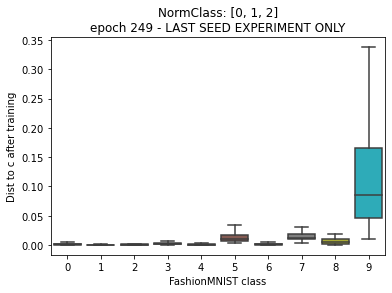

In [7]:
# useless graph here since we only have one centroid in the latent space anyway to compute a distance / score, reproduced for consistency between notebooks
plt.figure()
boxplot(y=scores_per_center_test.cpu().numpy(), x=scores_labels_test, showfliers=False)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Dist to c after training')
plt.title('NormClass: {}\nepoch {} - LAST SEED EXPERIMENT ONLY'.format(normal_cls, epoch))

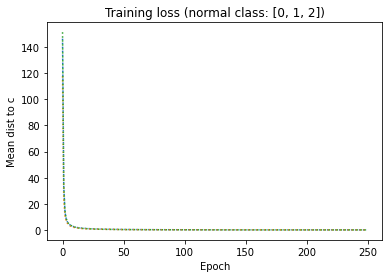

In [8]:
plt.figure()
for seed_idx in range(nbr_seeds):
    plt.plot(range(nbr_epochs), losses[seed_idx,:], linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Mean dist to c')
    plt.title('Training loss (normal class: {})'.format(normal_cls))

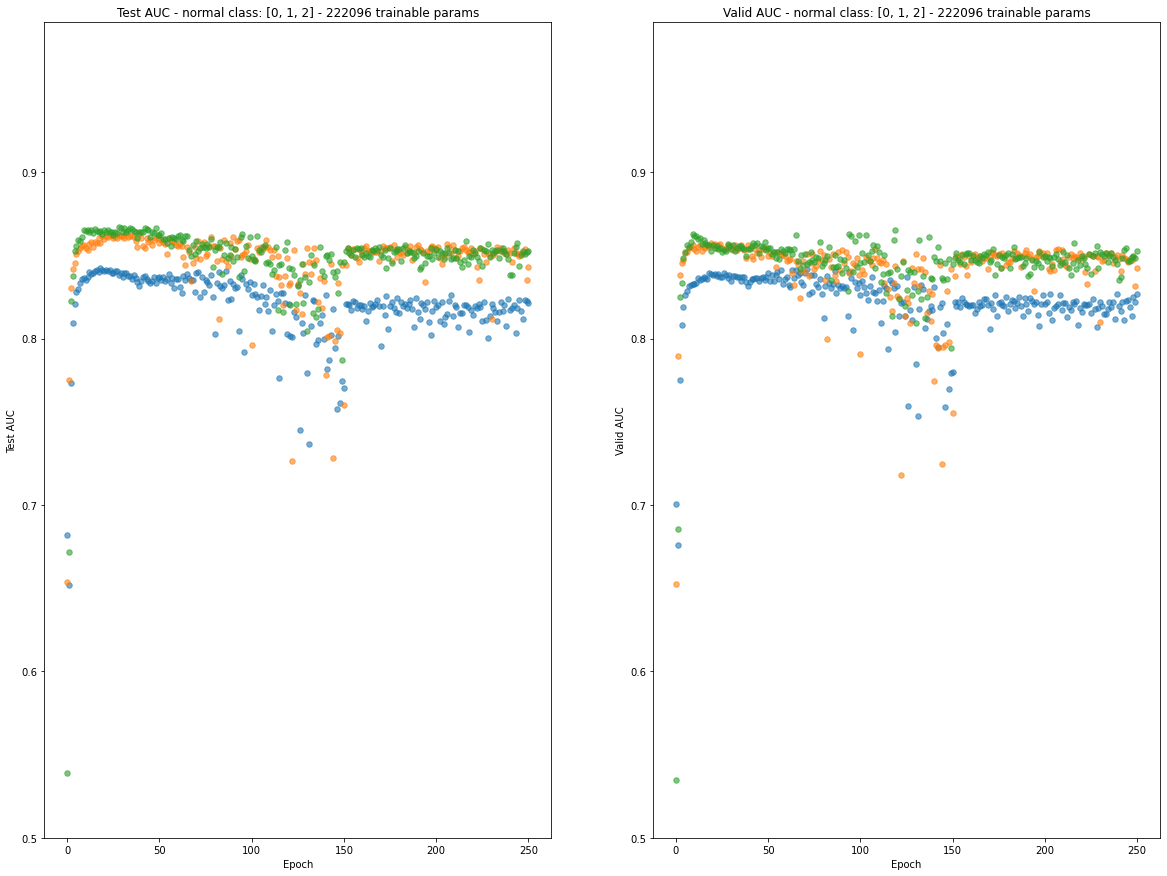

In [9]:
plt.figure(figsize=(20, 15)) 

plt.subplot(1,2,1)
for seed_idx in range(nbr_seeds):
    plt.scatter(range(0, nbr_epochs+1), test_AUCs[seed_idx,:], alpha=0.6, s=30)
    plt.ylim(0.5,0.99)
    plt.xlabel('Epoch')
    plt.ylabel('Test AUC')
    plt.title('Test AUC - normal class: {} - {} trainable params'.format(normal_cls, pytorch_total_params))
    
plt.subplot(1,2,2)
for seed_idx in range(nbr_seeds):
    plt.scatter(range(0, nbr_epochs+1), valid_AUCs[seed_idx,:], alpha=0.6, s=30)
    plt.ylim(0.5,0.99)
    plt.xlabel('Epoch')
    plt.ylabel('Valid AUC')
    plt.title('Valid AUC - normal class: {} - {} trainable params'.format(normal_cls, pytorch_total_params))

In [10]:
test_AUC_at_best_valid = torch.gather(test_AUCs,1,torch.max(valid_AUCs, dim=1)[1].long().unsqueeze(1))
test_AUC_at_best_test = torch.gather(test_AUCs,1,torch.max(test_AUCs, dim=1)[1].long().unsqueeze(1))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUC_at_best_valid),torch.std(test_AUC_at_best_valid)))

MEAN TEST AUC +/- STD: 0.8533704280853271 +/- 0.011627436615526676


In [11]:
with open('last_results.txt', "a") as file:
    file.write("DeepSVDD-{}-Norm{}-BSize{}-LR{}-{}epochs-{}seeds-Pretr{} - MEAN TEST AUC (best valid epoch) +/- STD: {} +/- {} | MEAN TEST AUC (best test epoch) +/- STD: {} +/- {}\n".format(dataset, normal_cls, batch_size, learning_rate, nbr_epochs, nbr_seeds, use_pretraining, torch.mean(test_AUC_at_best_valid),torch.std(test_AUC_at_best_valid),torch.mean(test_AUC_at_best_test),torch.std(test_AUC_at_best_test)))